In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!unzip "/content/drive/My Drive/A_05_Part_02_Dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: A_05_Part_02_Dataset/Train/normal/52f18c9e-7262-4fcc-a6bc-78e707214886.png  
  inflating: A_05_Part_02_Dataset/Train/normal/52f53bb5-81fb-408b-adc7-2f8ae8932b31.png  
  inflating: A_05_Part_02_Dataset/Train/normal/52fee036-272a-455a-9714-b6ff73e28403.png  
  inflating: A_05_Part_02_Dataset/Train/normal/535c2337-e755-43ea-ab1d-6547a584776d.png  
  inflating: A_05_Part_02_Dataset/Train/normal/536ba3bf-b867-4035-b483-35e9cbda9c0f.png  
  inflating: A_05_Part_02_Dataset/Train/normal/538d24ba-8a55-4445-b0d5-f9e5812fdd49.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53bae9fc-3bb2-4684-b986-84bf7aa2e5a2.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53bed796-1a7b-406b-b37c-d37facb41158.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53c275e1-e692-4445-bb4f-b740d117712f.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53c369ae-d8f9-4e44-b212-c6e2dc6ef580.png  
  inflating: A_05_Part_02_Dataset/Train/normal/53

**Import Libraries**

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import copy
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score, multilabel_confusion_matrix
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.5.0+cu101
Torchvision Version:  0.6.0+cu101


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Variable Initialization**

In [0]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = '/content/A_05_Part_02_Dataset'

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 16

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

input_size = 224

**Plot Loss and Accuracy Curve**

In [0]:
def plot_loss_accuracy(train_accuracy, valid_accuracy, train_loss, valid_loss, plot_err=True):
  fig, f =  plt.subplots(1,2,figsize=(15,5))
  #plot accuracy curve
  f[0].plot(train_accuracy, label='Training Accuracy');
  if valid_accuracy:
      f[0].plot(valid_accuracy, label='Validation Accuracy');
  f[0].legend()
  
  f[0].set_xlabel('Epochs')
  f[0].set_ylabel('Accuracy')
  # plot error of the model if plot_err is true
  if plot_err == True:
      f[1].plot(train_loss, label='Train Loss');
      f[1].plot(valid_loss, label='Validation Loss', color='blue' )
      f[1].set_xlabel('Epochs')
      f[1].set_ylabel('Loss')
      f[1].legend()

**Confusion Matrix**

In [0]:
def confusionMatrix3x3(y_pred,y):
    matrix = np.zeros((3,3), dtype='int')
    for i, j in zip(y,y_pred):
        matrix[i.item()][j.item()]+=1
    return matrix

**One Hot Encoding**

In [0]:
def oneHotEncoding(labels):
  y_onehot = labels.numpy()
  y_onehot = (np.arange(num_classes) == y_onehot[:,None]).astype(np.float32)
  y_onehot = torch.from_numpy(y_onehot)
  for i in y_onehot:
    if i[0] == 1:
      i[0] = 1
      i[2] = 1
  return y_onehot 

def oneHotDecoding(labels):
  temp = []
  y_onehot = labels.cpu().numpy()
  y_onehot = torch.from_numpy(y_onehot)
  for i in y_onehot:
    if i[0] == 1 and i[2] == 1:
      temp.append(0)
    elif i[1] == 1:
      temp.append(1)
    elif i[2] == 1:
      temp.append(2)
    else:
      temp.append(3)
  return np.array(temp) 

**Probabilities to labels**

In [0]:
def labelPrediction(labels):
  for i in range(len(labels)):
    for j in range(len(labels[0])):
      if labels[i][j] > 0:
        labels[i][j] = 1
      else:
        labels[i][j] = 0
  return labels

def tupleLabels(labels):
  temp = []
  for label in labels:
    temp.append(tuple(i for i, x in enumerate(label) if x == 1))
  return temp

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

**Accuracy**

In [0]:
def calAccuracy(y_pred, y_true):
    accuracy = 0.0
    for r, x in zip(y_true, y_pred):
        intersect = set(r).intersection(set(x))
        union = set(r).union(set(x))
        accuracy += len(intersect)/len(union)
    return accuracy / len(y_pred)

**Precision, Recall, F1 Score**

In [0]:
def precision(y_pred, y_true):
  N = len(y_true)
  intersect = 0
  prec = 0
  for i, j in zip(y_true, y_pred):
    intersect = set(i).intersection(set(j))
    prec += len(intersect) / (len(j) + 0.00001)
  return prec / N

def recall(y_pred, y_true):
  N = len(y_true)
  intersect = 0
  recl = 0
  for i, j in zip(y_true, y_pred):
    intersect = set(i).intersection(set(j))
    recl += len(intersect) / (len(i) + + 0.00001)
  return recl / N

def F1_score(y_pred, y_true):
  prec = precision(y_pred, y_true)
  recl = recall(y_pred, y_true)
  return (2 *  prec * recl) / (prec + recl)

**Function: Accuracy, F1 Score, Confusion Matrix measure**

In [0]:
def accuracy_measures(model):
      with torch.no_grad():
        # train
        y_true, y_pred = [], []
        cm = np.zeros((3,2,2))
        itr, res, f1score = 0, 0, 0
        for data in dataloaders_dict['Train']:
            itr += 1
            images, labels = data
            oneHotLabels = oneHotEncoding(labels)
            images, oneHotLabels = images.to(device), oneHotLabels.to(device)
            outputs = model(images)
            y_true.append(oneHotLabels.cpu())
            y_pred.append(labelPrediction(outputs).cpu())
            res += calAccuracy(tupleLabels(labelPrediction(outputs)), tupleLabels(oneHotLabels))
            f1score += F1_score(tupleLabels(labelPrediction(outputs)), tupleLabels(oneHotLabels))
            cm += multilabel_confusion_matrix(oneHotLabels.cpu(), labelPrediction(outputs).cpu())
        #for i in cm:
        print('Accuracy of the network on the train images: %d %%' % (100 * res / itr))
        #f1score = F1_score(y_pred, y_true)
        print('Train F1 Score: ', f1score/ itr)
        print('Training Confusion Matrix: \n')
        plotCM(cm)

        # validation
        y_true, y_pred = [], []
        cm = np.zeros((3,2,2))
        itr, res, f1score = 0, 0, 0
        for data in dataloaders_dict['Validation']:
            itr += 1
            images, labels = data
            oneHotLabels = oneHotEncoding(labels)
            images, oneHotLabels = images.to(device), oneHotLabels.to(device)
            outputs = model(images)
            y_true.append(oneHotLabels.cpu())
            y_pred.append(labelPrediction(outputs).cpu())
            res += calAccuracy(tupleLabels(labelPrediction(outputs)), tupleLabels(oneHotLabels))
            f1score += F1_score(tupleLabels(labelPrediction(outputs)), tupleLabels(oneHotLabels))
            cm += multilabel_confusion_matrix(oneHotLabels.cpu(), labelPrediction(outputs).cpu())
        print('Accuracy of the network on the validation images: %d %%' % (100 * res / itr))
        #f1score = F1_score(y_pred, y_true)
        print('Validation F1 Score: ', f1score / itr)
        print('Validation Confusion Matrix: \n')
        plotCM(cm)
def plotCM(cm, cls = ['COVID-19', 'NORMAL', 'PNOUMONIA']):
    for i, c in zip(cm, cls):
        fig, f1 = plt.subplots(1, figsize = (5,5))
        fig.suptitle(c + ' Accuracy Matrix ')
        ax = f1
        sns.heatmap(i.astype(int), annot=True, annot_kws={"size": 10}, ax = ax, fmt='g')
        ax.xaxis.set_ticklabels(['0', '1']) 
        ax.yaxis.set_ticklabels(['0', '1'])

**Function: Focal Loss**

In [0]:
class FocalLoss(nn.Module):
    def _init_(self, alpha=1, gamma=2):
        super(FocalLoss, self)._init_()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        
        bce_loss = - nn.functional.binary_cross_entropy_with_logits(inputs, targets)
        pt = torch.exp(bce_loss)
        F_loss = - 0.25 * ((1-pt)**2) * bce_loss
        return torch.mean(F_loss)

**Function: Model Initialization**

In [0]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(
            nn.Linear(num_ftrs, num_classes),
            )
        input_size = 224

    elif model_name == "vgg":
        """ VGG16
        """
        model_ft = models.vgg16(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_features = model_ft.classifier[6].in_features
        features = list(model_ft.classifier.children())[:-1] # Remove last layer
        features.extend([nn.Linear(num_features, num_classes)])
        model_ft.classifier = nn.Sequential(*features)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

**Load data from directiories**

In [13]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'Train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Validation': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training, validation and test datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Train', 'Validation']}
# Create training, validation and test dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['Train', 'Validation']}



Initializing Datasets and Dataloaders...


**Function: Train Model**

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False, saveModelName = ''):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_accuracy = []
    valid_accuracy = []
    train_loss = []
    valid_loss = []
    for epoch in range(num_epochs):
        start_time = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Validation']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_incorrects = 0
            res = 0
            q = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                oneHotLabels = oneHotEncoding(labels)
                inputs = inputs.to(device)
                labels = labels.to(device)
                oneHotLabels = oneHotLabels.to(device)
                q += 1
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    if is_inception and phase == 'Train':
                        outputs = model(inputs)
                        loss = criterion(outputs, oneHotLabels)
                        _, tpreds = torch.max(outputs, 1)
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, oneHotLabels)
                        _, vpreds = torch.max(outputs, 1)

                    #_, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() #* inputs.size(0)
                
                #print('Predicted: ', labelPrediction(outputs), '\n Ground Truth: ', oneHotLabels)
                res += calAccuracy(tupleLabels(labelPrediction(outputs)), tupleLabels(oneHotLabels))

            if phase == 'Train':
                epoch_loss = running_loss / len(dataloaders[phase].dataset)
                train_loss.append(epoch_loss)
                epoch_acc = res / q
                train_accuracy.append(epoch_acc)
                time_end = (time.time() - start_time)
                print('{} Loss: {:.4f} Acc: {:.4f} Execution Time {}'.format(phase, epoch_loss, epoch_acc, str(time_end // 60) + 'm ' + str(time_end % 60) + 's'))
            else:
                epoch_loss = running_loss / len(dataloaders[phase].dataset)
                valid_loss.append(epoch_loss)
                epoch_acc = res / q 
                valid_accuracy.append(epoch_acc)
                time_end = (time.time() - start_time)
                print('{} Loss: {:.4f} Acc: {:.4f} Execution Time {}'.format(phase, epoch_loss, epoch_acc, str(time_end // 60) + 'm ' + str(time_end % 60) + 's'))

            # deep copy the model
            if phase == 'Validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'Validation':
                val_acc_history.append(epoch_acc)

        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    plot_loss_accuracy(train_accuracy, valid_accuracy, train_loss, valid_loss, plot_err=True)
    # load best model weights
    model.load_state_dict(best_model_wts)
    path = F"/content/drive/My Drive/A5B/weights/{saveModelName}" 
    torch.save(model.state_dict(), path+'FC_Only.pth')
    return model, val_acc_history

**ResNet-18: Binary Cross Entropy with Logistic**

In [15]:

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the model for this run
resnet18, input_size = initialize_model(model_name='resnet', num_classes=num_classes, feature_extract=False, use_pretrained=True)

# Print the model we just instantiated
print(resnet18)

# Send the model to GPU
resnet18 = resnet18.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = resnet18.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in resnet18.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in resnet18.named_parameters():
        if param.requires_grad == True:
            print("\t",name)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 0/19
----------
Train Loss: 0.0148 Acc: 0.8521 Execution Time 1.0m 47.874136447906494s
Validation Loss: 0.0101 Acc: 0.9047 Execution Time 1.0m 58.6033992767334s

Epoch 1/19
----------
Train Loss: 0.0096 Acc: 0.9140 Execution Time 1.0m 47.46489477157593s
Validation Loss: 0.0094 Acc: 0.9219 Execution Time 1.0m 58.28170132637024s

Epoch 2/19
----------
Train Loss: 0.0070 Acc: 0.9394 Execution Time 1.0m 46.77591943740845s
Validation Loss: 0.0080 Acc: 0.9352 Execution Time 1.0m 57.456968784332275s

Epoch 3/19
----------
Train Loss: 0.0052 Acc: 0.9522 Execution Time 1.0m 46.815531492233276s
Validation Loss: 0.0080 Acc: 0.9219 Execution Time 1.0m 57.54252314567566s

Epoch 4/19
----------
Train Loss: 0.0036 Acc: 0.9704 Execution Time 1.0m 47.08614492416382s
Validation Loss: 0.0096 Acc: 0.9349 Execution Time 1.0m 57.68167853355408s

Epoch 5/19
----------
Train Loss: 0.0026 Acc: 0.9791 Execution Time 1.0m 45.44182085990906s
Validation Loss: 0.0117 Acc: 0.9310 Execution Time 1.0m 55.7965013

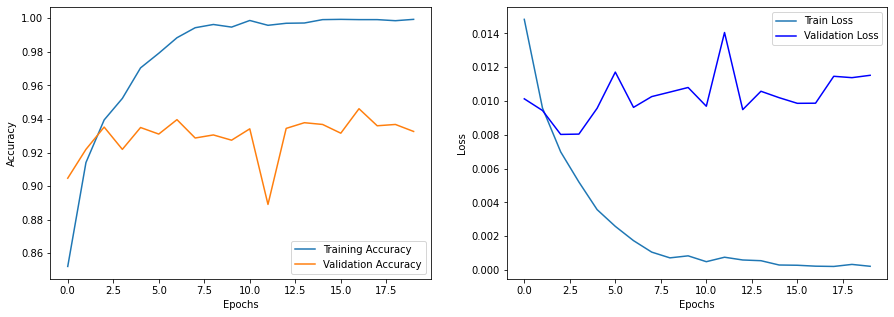

In [0]:
# lr = 0.001, batch_size = 16, epoch = 20, 1 FC Layer, Loss = BCEWithLogitsLoss(), No Sigmoid
# Observe that all parameters are being optimize
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Setup the loss fxn
criterion = nn.BCEWithLogitsLoss()

# Train and evaluate
resnet181, hist = train_model(resnet18, dataloaders_dict, criterion, optimizer_ft, num_epochs=20, is_inception=(model_name=="resnet"), saveModelName='resnet181_A5-P2-1')


 
 Accuracy of the network on the train images: 99 %
Train F1 Score:  0.9991438476457409
Training Confusion Matrix: 
 None

 
 Accuracy of the network on the validation images: 93 %
Validation F1 Score:  0.9323927626085748
Validation Confusion Matrix: 
 None


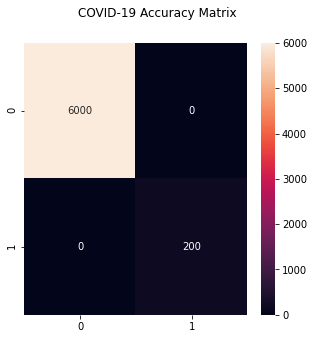

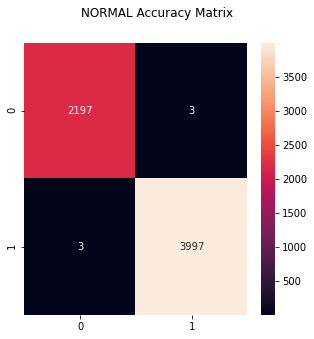

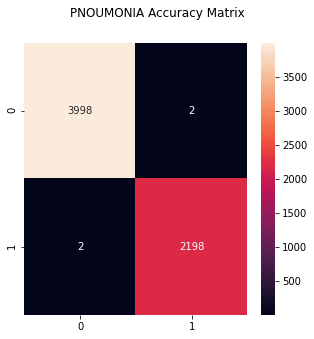

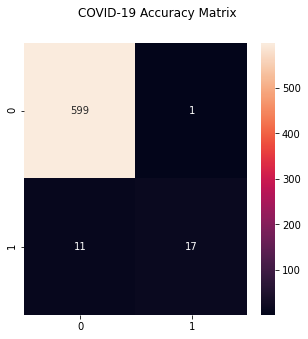

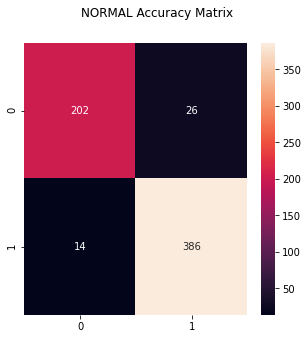

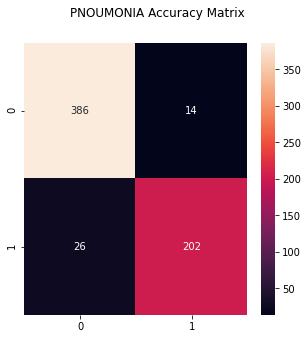

In [16]:
resnet18.load_state_dict(torch.load('/content/drive/My Drive/A5B/weights/resnet18_BCE.pth'))
accuracy_measures(resnet18)

**VGG-16: Binary Cross Entropy with Logistic**

In [18]:
# Initialize the model for this run
vgg16, input_size = initialize_model(model_name='vgg', num_classes=num_classes, feature_extract=False, use_pretrained=True)

# Print the model we just instantiated
print(vgg16)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
vgg16 = vgg16.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = vgg16.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in vgg16.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in vgg16.named_parameters():
        if param.requires_grad == True:
            print("\t",name)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

Epoch 0/11
----------
Train Loss: 0.0092 Acc: 0.9177 Execution Time 3.0m 27.926116704940796s
Validation Loss: 0.0082 Acc: 0.9365 Execution Time 3.0m 43.31989598274231s

Epoch 1/11
----------
Train Loss: 0.0071 Acc: 0.9369 Execution Time 3.0m 27.986971378326416s
Validation Loss: 0.0072 Acc: 0.9466 Execution Time 3.0m 42.2369339466095s

Epoch 2/11
----------
Train Loss: 0.0055 Acc: 0.9512 Execution Time 3.0m 28.141120195388794s
Validation Loss: 0.0092 Acc: 0.9299 Execution Time 3.0m 43.28847122192383s

Epoch 3/11
----------
Train Loss: 0.0045 Acc: 0.9610 Execution Time 3.0m 27.490320444107056s
Validation Loss: 0.0060 Acc: 0.9521 Execution Time 3.0m 41.807422399520874s

Epoch 4/11
----------
Train Loss: 0.0030 Acc: 0.9736 Execution Time 3.0m 27.136492490768433s
Validation Loss: 0.0111 Acc: 0.9229 Execution Time 3.0m 41.52536654472351s

Epoch 5/11
----------
Train Loss: 0.0023 Acc: 0.9787 Execution Time 3.0m 27.83946681022644s
Validation Loss: 0.0103 Acc: 0.9240 Execution Time 3.0m 42.0795

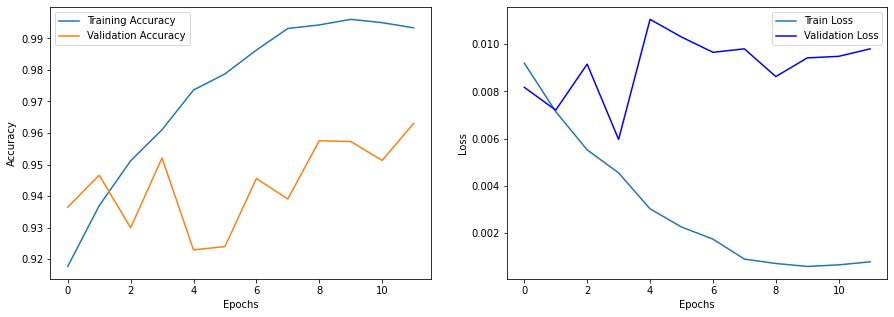

In [0]:
# lr = 0.001, batch_size = 16, epoch = 20, 1 FC Layer, Loss = BCEWithLogitsLoss(), No Sigmoid
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Setup the loss fxn
criterion = nn.BCEWithLogitsLoss()

# Train and evaluate
vgg16, hist = train_model(vgg16, dataloaders_dict, criterion, optimizer_ft, num_epochs=12, is_inception=(model_name=="vgg"), saveModelName='vgg16_BCE')

Accuracy of the network on the train images: 99 %
Train F1 Score:  0.9991029368171029
Training Confusion Matrix: 

Accuracy of the network on the validation images: 95 %
Validation F1 Score:  0.9554324398965889
Validation Confusion Matrix: 



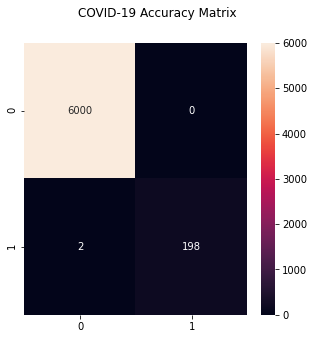

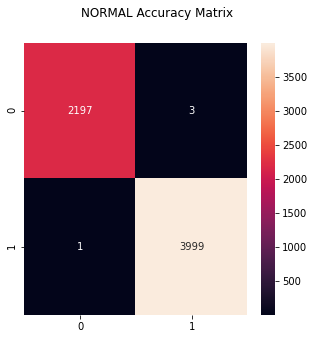

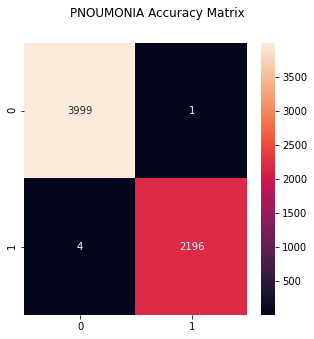

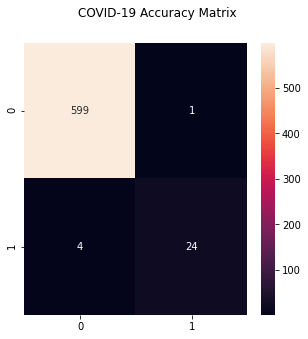

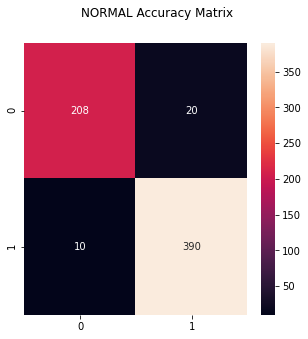

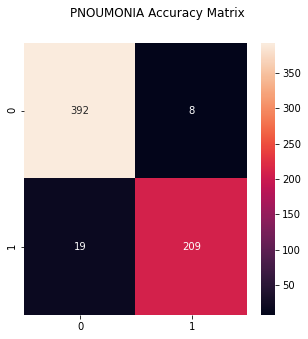

In [19]:
vgg16.load_state_dict(torch.load('/content/drive/My Drive/A5B/weights/vgg16_BCE.pth'))
accuracy_measures(vgg16)

In [49]:
class ImageFolderWithPaths(datasets.ImageFolder):

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

data_dir = "/content/A_05_Part_02_Dataset/Test"
test_data = ImageFolderWithPaths(data_dir, transform=test_transforms) # our custom dataset
testloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False, num_workers=0)
test_transforms = transforms.Compose([transforms.Resize(input_size),
                                      transforms.CenterCrop(input_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                  ])

vgg16 = vgg16
vgg16.to(device)
print()

testList = []
vgg16.eval()
with torch.no_grad():
    for images, labels, paths in tqdm(testloader):
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        predicted = labelPrediction(outputs.data).to(device)
        head, tail = os.path.split(paths[0])
        testList.append([tail, int(predicted[0][0].item()), int(predicted[0][2].item()), int(predicted[0][1].item())])

  1%|          | 4/629 [00:00<00:19, 32.26it/s]

100%|██████████| 629/629 [00:19<00:00, 32.13it/s]


In [50]:
# dislay first 10 results
results = pd.DataFrame(testList)
results.head(10)

,0,1,2,3
0,0.png,0,0,1
1,1.png,0,0,1
2,10.png,0,0,1
3,100.png,0,1,0
4,101.png,0,0,1
5,102.png,0,0,1
6,103.png,0,0,1
7,104.jpg,1,0,1
8,105.jpg,1,1,0
9,106.png,0,0,1


In [0]:
# save results in csv file
results.to_csv('msds19077_results.csv', encoding='utf-8', index=False, header=False)

**Focal Loss**

**ResNet-18**

In [20]:

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the model for this run
resnet18fl, input_size = initialize_model(model_name='resnet', num_classes=num_classes, feature_extract=False, use_pretrained=True)

# Print the model we just instantiated
print(resnet18fl)

# Send the model to GPU
resnet18fl = resnet18fl.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = resnet18fl.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in resnet18fl.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in resnet18fl.named_parameters():
        if param.requires_grad == True:
            print("\t",name)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 0/19
----------
Train Loss: 0.0008 Acc: 0.6995 Execution Time 1.0m 50.722888231277466s
Validation Loss: 0.0005 Acc: 0.7885 Execution Time 2.0m 1.8218867778778076s

Epoch 1/19
----------
Train Loss: 0.0004 Acc: 0.8094 Execution Time 1.0m 50.11443042755127s
Validation Loss: 0.0004 Acc: 0.8354 Execution Time 2.0m 1.1752238273620605s

Epoch 2/19
----------
Train Loss: 0.0003 Acc: 0.8330 Execution Time 1.0m 50.75439095497131s
Validation Loss: 0.0003 Acc: 0.8378 Execution Time 2.0m 1.7033910751342773s

Epoch 3/19
----------
Train Loss: 0.0003 Acc: 0.8462 Execution Time 1.0m 49.91770672798157s
Validation Loss: 0.0003 Acc: 0.8570 Execution Time 2.0m 0.8716542720794678s

Epoch 4/19
----------
Train Loss: 0.0002 Acc: 0.8640 Execution Time 1.0m 49.701244831085205s
Validation Loss: 0.0003 Acc: 0.8531 Execution Time 2.0m 0.7126591205596924s

Epoch 5/19
----------
Train Loss: 0.0002 Acc: 0.8676 Execution Time 1.0m 49.978846311569214s
Validation Loss: 0.0002 Acc: 0.8802 Execution Time 2.0m 1.04

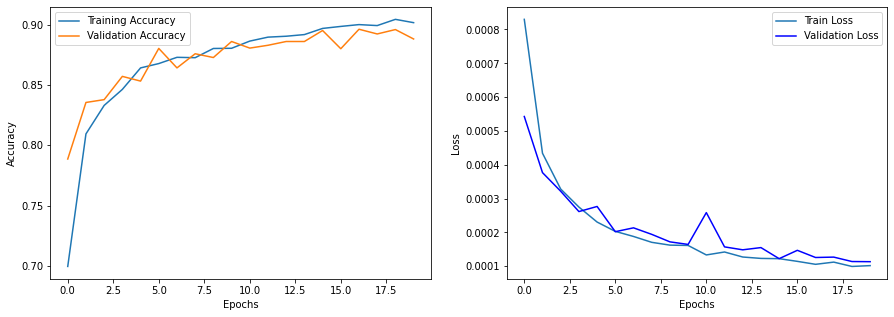

In [83]:
# lr = 0.001, batch_size = 16, epoch = 20, 1 FC Layer, Loss = FocalLoss(), No Sigmoid
# Observe that all parameters are being optimize
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Setup the loss fxn
criterion = FocalLoss()

# Train and evaluate
resnet18_fl, hist = train_model(resnet18fl, dataloaders_dict, criterion, optimizer_ft, num_epochs=20, is_inception=(model_name=="resnet"), saveModelName='resnet18_Focal_Loss')

Accuracy of the network on the train images: 90 %
Train F1 Score:  0.9100660531303797
Training Confusion Matrix: 

Accuracy of the network on the validation images: 88 %
Validation F1 Score:  0.8935347243205042
Validation Confusion Matrix: 



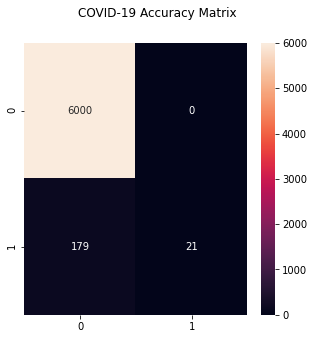

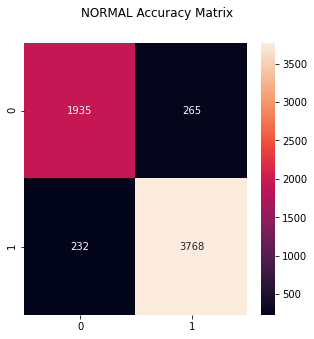

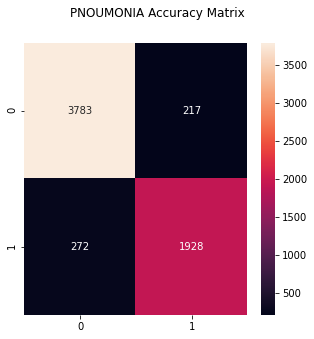

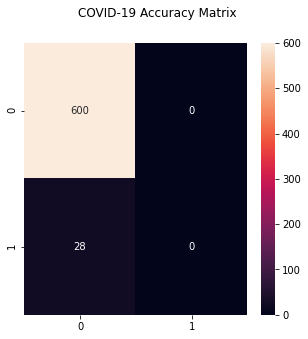

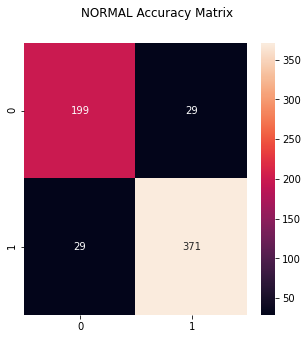

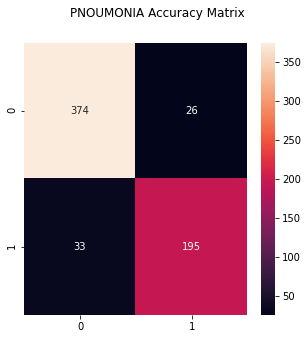

In [23]:
resnet18fl.load_state_dict(torch.load('/content/drive/My Drive/A5B/weights/resnet18_Focal_Loss.pth'))
accuracy_measures(resnet18fl)

**VGG-16**

In [24]:
# Initialize the model for this run
vgg16fl, input_size = initialize_model(model_name='vgg', num_classes=num_classes, feature_extract=False, use_pretrained=True)

# Print the model we just instantiated
print(vgg16fl)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
vgg16fl = vgg16fl.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = vgg16fl.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in vgg16fl.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in vgg16fl.named_parameters():
        if param.requires_grad == True:
            print("\t",name)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Epoch 0/19
----------
Train Loss: 0.0006 Acc: 0.7700 Execution Time 3.0m 24.875375986099243s
Validation Loss: 0.0003 Acc: 0.8578 Execution Time 3.0m 37.13138723373413s

Epoch 1/19
----------
Train Loss: 0.0002 Acc: 0.8575 Execution Time 3.0m 25.446832418441772s
Validation Loss: 0.0002 Acc: 0.8758 Execution Time 3.0m 37.92354989051819s

Epoch 2/19
----------
Train Loss: 0.0002 Acc: 0.8724 Execution Time 3.0m 25.287161111831665s
Validation Loss: 0.0002 Acc: 0.8828 Execution Time 3.0m 37.621644496917725s

Epoch 3/19
----------
Train Loss: 0.0001 Acc: 0.8843 Execution Time 3.0m 25.535555839538574s
Validation Loss: 0.0001 Acc: 0.8961 Execution Time 3.0m 37.62382197380066s

Epoch 4/19
----------
Train Loss: 0.0001 Acc: 0.8919 Execution Time 3.0m 24.720929384231567s
Validation Loss: 0.0001 Acc: 0.9031 Execution Time 3.0m 36.597068309783936s

Epoch 5/19
----------
Train Loss: 0.0001 Acc: 0.8943 Execution Time 3.0m 24.761035919189453s
Validation Loss: 0.0001 Acc: 0.8961 Execution Time 3.0m 36.6

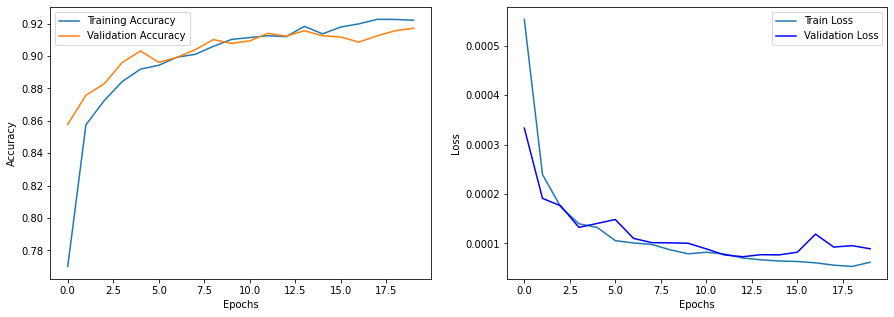

In [23]:
# lr = 0.001, batch_size = 16, epoch = 20, 1 FC Layer, Loss = FocalLoss(), No Sigmoid
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Setup the loss fxn
criterion = FocalLoss()

# Train and evaluate
vgg16_fl, hist = train_model(vgg16fl, dataloaders_dict, criterion, optimizer_ft, num_epochs=20, is_inception=(model_name=="vgg"), saveModelName='vgg16_Focal_Loss')

Accuracy of the network on the train images: 92 %
Train F1 Score:  0.9324348495525677
Training Confusion Matrix: 

Accuracy of the network on the validation images: 90 %
Validation F1 Score:  0.914688991005141
Validation Confusion Matrix: 



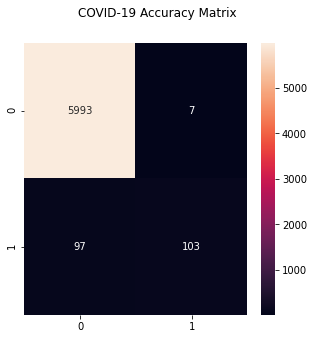

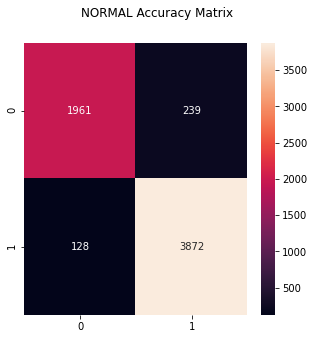

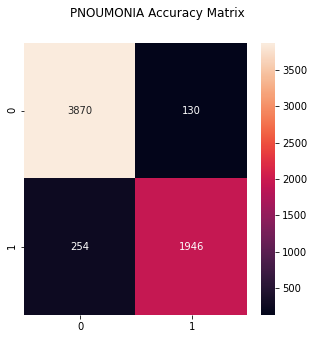

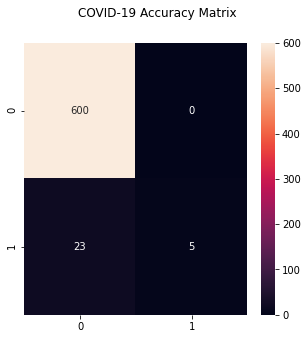

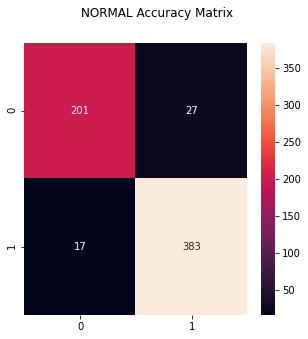

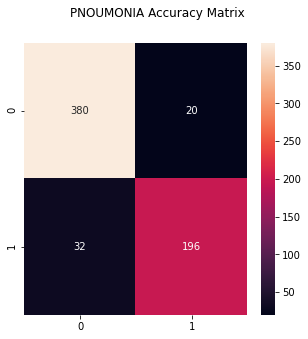

In [25]:
vgg16fl.load_state_dict(torch.load('/content/drive/My Drive/A5B/weights/vgg16_Focal_Loss.pth'))
accuracy_measures(vgg16fl)